In [1]:
from imp import reload
import sys
# import rpy2
import os
import os.path
from glob import glob
import numpy as np
import pandas as pd
pd.show_versions()
from scipy import stats
import statsmodels.stats.api as sms
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.use14corefonts'] = True
#matplotlib.rcParams['text.usetex'] = False
# Use Type 1 fonts in plots.
matplotlib.rc('pdf', fonttype=42)
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm



INSTALLED VERSIONS
------------------
commit           : None
python           : 3.8.5.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.8.0-41-generic
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_GB.UTF-8
LOCALE           : en_GB.UTF-8

pandas           : 0.25.3
numpy            : 1.17.4
pytz             : 2019.3
dateutil         : 2.7.3
pip              : 20.0.2
setuptools       : 45.2.0
Cython           : None
pytest           : 4.6.9
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : 4.5.0
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10.1
IPython          : 7.13.0
pandas_datareader: None
bs4              : 4.8.2
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.5.0
matplotlib       : 3.1.2
numexpr    

# Real datasets (LOP, PFSP, QAP)
In the following lines we load the results of the real dataset for CEGO and UMM, plot the results and make the comparison table

In [3]:
dfbest = pd.read_csv('best_fitness_selected.csv',sep=';')
def get_opt(instpath):
  instance_name = instpath.split('/')[-1].replace('.dat','').replace('.txt','')
  sol = dfbest[dfbest.instance_name==instance_name]#.best_known_subdiagonal.values
  if len(sol) != 1: 
    print("No opt value")
    return np.nan
  if sol.best_known_subdiagonal.isna().bool():
      return sol.best_known.iloc[0]
  else:
      return sol.best_known_subdiagonal.iloc[0]

def read_alldata(pat="./results/m1000-er0-dist_*/**/*.csv.xz"):
    lis = []
    for filename in glob(pat, recursive=True):
        tmp = pd.read_csv(filename)
        print(filename)
        tmp.instance = tmp.instance.str.replace('pfsp/','pfsp_cmax/')
        if "dist_hamming" in filename:
            tmp['Solver'] = tmp['Solver'] + "_hamming"
        if "dist_kendall" in filename:
            tmp['Solver'] = tmp['Solver'] + "_kendall"
        if "-er1-" in filename:
            tmp['Solver'] = tmp['Solver'] + "_er1"
        if "maxmindist" in filename:
            tmp['Solver'] = tmp['Solver'] + "_MaxMinDist"
        if "rank" in filename:
            tmp['Solver'] = tmp['Solver'] + "_rank"
        if "softmax" in filename:
            tmp['Solver'] = tmp['Solver'] + "_sm01"
        if "sm001" in filename:
            tmp['Solver'] = tmp['Solver'] + "_sm001"
        if "sm1" in filename:
            tmp['Solver'] = tmp['Solver'] + "_sm1"
        if "smlen" in filename:
            tmp['Solver'] = tmp['Solver'] + "_smlen"
        if "noborda" in filename:
            tmp['Solver'] = tmp['Solver'] + "_nb"
        lis.append(tmp)
    return pd.concat(lis, sort = True)

def check_runs(df, nruns):
    df2 = df.groupby(['Solver', 'instance',"eval_ranks","budget","Function evaluations"])['seed'].sum()
    totalruns = np.arange(1, nruns + 1).sum()
    assert (df2 == totalruns).all(),f"{df2[df2 != totalruns]}"
    assert (df.groupby(['Solver', 'instance',"eval_ranks","budget","Function evaluations"])['seed'].nunique() == nruns).all()

# If runs were terminated after different number of evaluations, 
# use only the evaluations reached in all runs to avoid misleading mean and variance.
def filter_unequal_budget(df, budget):
    df_max_evals = df[df.Solver.str.startswith("CEGO")].groupby(['Solver','instance','eval_ranks','seed'])['Function evaluations'].max().groupby(['Solver','instance','eval_ranks']).min()
    for index,row  in df_max_evals.reset_index().iterrows():
        if row['Function evaluations'] == budget: continue
        before = df.shape[0]
        df = df[~((df.Solver == row.Solver) & (df.instance == row.instance) & (df.eval_ranks == row.eval_ranks) & (df['Function evaluations'] > row['Function evaluations']))]
        print(f"Removed {before - df.shape[0]} rows for Solver={row.Solver} instance={row.instance} eval_ranks={row.eval_ranks}")
    return df

df = read_alldata()
# This is only for synthetic LOPs
#df['Uniformity'] = df.instance.str.extract(r'phi=(.+)$').astype(float)
# These are the instances used in the paper
sel_insts = ['lop/IO/N-t59d11xx' ,'lop/IO/N-t59b11xx' ,'lop/SGB/N-sgb75.01' ,'lop/SGB/N-sgb75.02',
             'lop/RandB/N-p40-01','lop/RandB/N-p40-02' ,'lop/RandB/N-p50-02', 'lop/RandB/N-p50-01',
             'pfsp_cmax/rec05.txt','pfsp_cmax/rec13.txt', 'pfsp_cmax/rec19.txt',  'pfsp_cmax/rec31.txt']
sel_insts = None
if sel_insts:
    df = df[(mask) & (df.instance.isin(sel_insts))]
else:
    sel_insts = df.instance.unique()
nruns = 20
df = filter_unequal_budget(df, 1000)
# Checks that make sure we have the correct number of runs
check_runs(df, 20)


./results/m1000-er0-dist_hamming/lop/RandB/N-p40-02/umm-random-learn_exp-samp_log.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p40-02/cego.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p50-02/umm-random-learn_exp-samp_log.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p50-02/cego.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p40-01/umm-random-learn_exp-samp_log.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p40-01/cego.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p50-01/umm-random-learn_exp-samp_log.csv.xz
./results/m1000-er0-dist_hamming/lop/RandB/N-p50-01/cego.csv.xz
./results/m1000-er0-dist_hamming/lop/SGB/N-sgb75.01/umm-random-learn_exp-samp_log.csv.xz
./results/m1000-er0-dist_hamming/lop/SGB/N-sgb75.01/cego.csv.xz
./results/m1000-er0-dist_hamming/lop/SGB/N-sgb75.02/umm-random-learn_exp-samp_log.csv.xz
./results/m1000-er0-dist_hamming/lop/SGB/N-sgb75.02/cego.csv.xz
./results/m1000-er0-dist_hamming/lop/IO/N-t59b11xx/umm-random-learn_exp-samp_log.c

AssertionError: Solver       instance             eval_ranks  budget  Function evaluations
UMM_hamming  pfsp_cmax/rec05.txt  0           1000    1                       55
                                                      2                       55
                                                      3                       55
                                                      4                       55
                                                      5                       55
                                                                              ..
UMM_kendall  pfsp_cmax/rec31.txt  0           1000    996                     55
                                                      997                     55
                                                      998                     55
                                                      999                     55
                                                      1000                    55
Name: seed, Length: 6000, dtype: int64

In [39]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None,'display.width', None,'display.max_colwidth', -1):
    print(df.groupby(["Solver","instance"])['seed'].unique())
    print(df.groupby(["Solver","instance"])['seed'].sum())

Solver        instance           
CEGO_hamming  lop/IO/N-t59b11xx      [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/IO/N-t59d11xx      [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/RandB/N-p40-01     [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/RandB/N-p40-02     [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/RandB/N-p50-01     [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/RandB/N-p50-02     [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/SGB/N-sgb75.01     [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              lop/SGB/N-sgb75.02     [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 5, 6, 7, 8, 9]
              pfsp_cmax/rec19.txt    [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 3, 4, 

## Plot results
Plot the fitness along iteration of the instances in the paper, LOP and PFSP

instance:  lop/RandB/N-p40-02
Solver        eval_ranks  budget
CEGO_hamming  0           1000      17420
CEGO_kendall  0           1000      18420
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  10683.0


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


Saving to img/fitness_lop_RandB_N-p40-02.pdf


findfont: Font family ['sans-serif'] not found. Falling back to Helvetica.


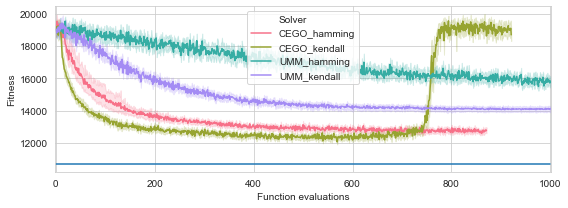

instance:  lop/RandB/N-p50-02
Solver        eval_ranks  budget
CEGO_hamming  0           1000      15620
CEGO_kendall  0           1000      17100
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  17269.0
Saving to img/fitness_lop_RandB_N-p50-02.pdf


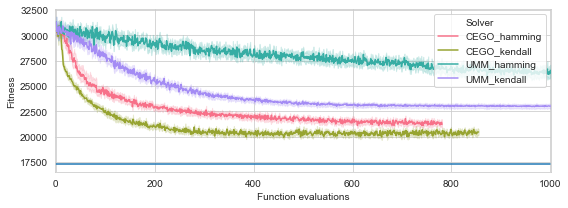

instance:  lop/RandB/N-p40-01
Solver        eval_ranks  budget
CEGO_hamming  0           1000      16500
CEGO_kendall  0           1000      18680
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  9663.0
Saving to img/fitness_lop_RandB_N-p40-01.pdf


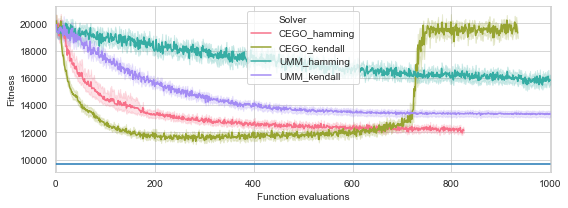

instance:  lop/RandB/N-p50-01
Solver        eval_ranks  budget
CEGO_hamming  0           1000      15740
CEGO_kendall  0           1000      17160
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  16673.0
Saving to img/fitness_lop_RandB_N-p50-01.pdf


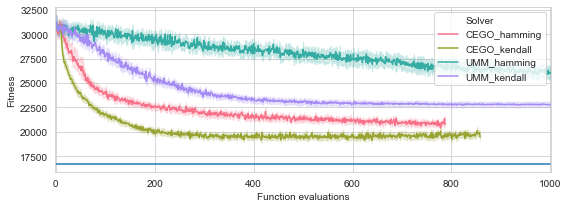

instance:  lop/SGB/N-sgb75.01
Solver        eval_ranks  budget
CEGO_hamming  0           1000       8500
CEGO_kendall  0           1000       8480
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  1632977.0
Saving to img/fitness_lop_SGB_N-sgb75_01.pdf


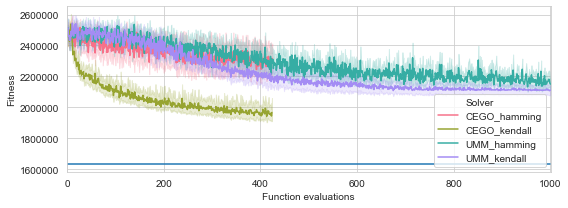

instance:  lop/SGB/N-sgb75.02
Solver        eval_ranks  budget
CEGO_hamming  0           1000       8460
CEGO_kendall  0           1000       8520
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  1613619.0
Saving to img/fitness_lop_SGB_N-sgb75_02.pdf


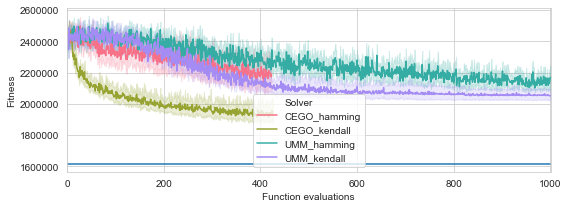

instance:  lop/IO/N-t59b11xx
Solver        eval_ranks  budget
CEGO_hamming  0           1000      11440
CEGO_kendall  0           1000      12560
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  93140.0
Saving to img/fitness_lop_IO_N-t59b11xx.pdf


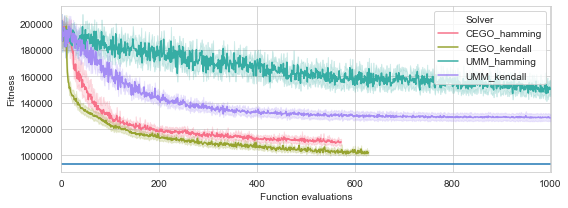

instance:  lop/IO/N-t59d11xx
Solver        eval_ranks  budget
CEGO_hamming  0           1000      11060
CEGO_kendall  0           1000      13420
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  9000.0
Saving to img/fitness_lop_IO_N-t59d11xx.pdf


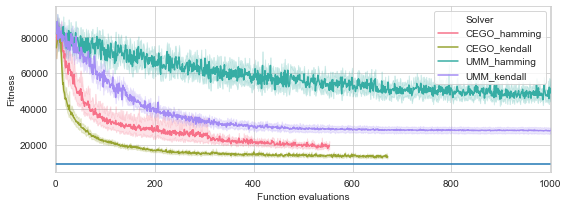

instance:  pfsp_cmax/rec31.txt
Solver        eval_ranks  budget
CEGO_hamming  0           1000      20000
CEGO_kendall  0           1000      20000
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      10000
dtype: int64
optimum:  3045
Saving to img/fitness_pfsp_cmax_rec31_txt.pdf


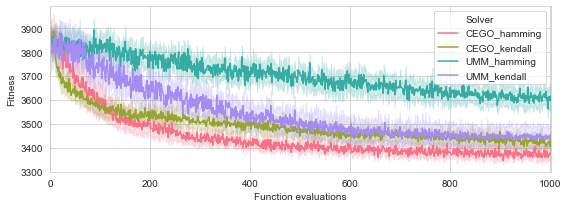

instance:  pfsp_cmax/rec13.txt
Solver        eval_ranks  budget
CEGO_kendall  0           1000      20000
UMM_hamming   0           1000      10000
UMM_kendall   0           1000      10000
dtype: int64
optimum:  1930
Saving to img/fitness_pfsp_cmax_rec13_txt.pdf


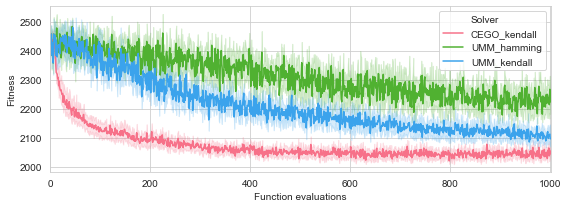

instance:  pfsp_cmax/rec05.txt
Solver        eval_ranks  budget
CEGO_kendall  0           1000      20000
UMM_hamming   0           1000      10000
UMM_kendall   0           1000      10000
dtype: int64
optimum:  1242
Saving to img/fitness_pfsp_cmax_rec05_txt.pdf


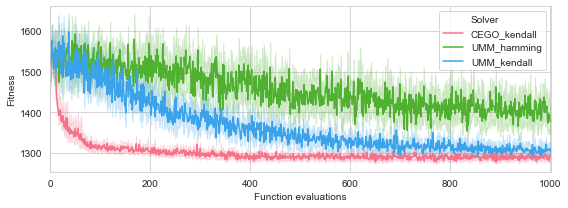

instance:  pfsp_cmax/rec19.txt
Solver        eval_ranks  budget
CEGO_hamming  0           1000      20000
CEGO_kendall  0           1000      20000
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      10000
dtype: int64
optimum:  2093
Saving to img/fitness_pfsp_cmax_rec19_txt.pdf


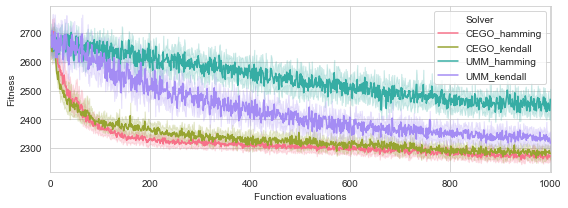

instance:  qap/nug30.dat
Solver        eval_ranks  budget
CEGO_hamming  0           1000      20000
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  6124
Saving to img/fitness_qap_nug30_dat.pdf


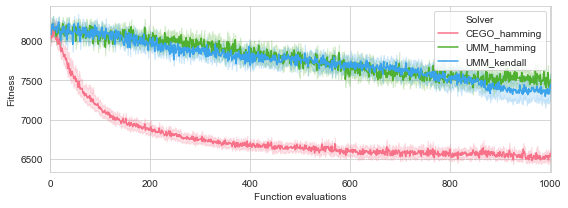

instance:  qap/tho30.dat
Solver        eval_ranks  budget
CEGO_hamming  0           1000      12700
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  149936
Saving to img/fitness_qap_tho30_dat.pdf


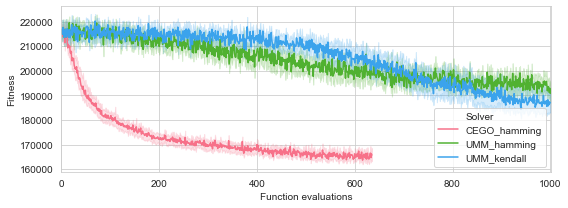

instance:  qap/kra32.dat
Solver        eval_ranks  budget
CEGO_hamming  0           1000      13400
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  88700
Saving to img/fitness_qap_kra32_dat.pdf


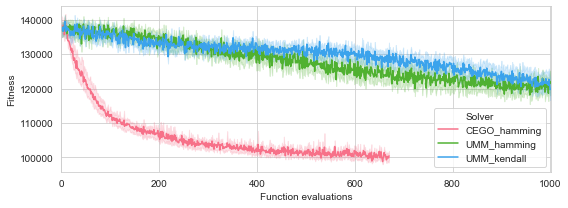

instance:  qap/nug12.dat
Solver        eval_ranks  budget
CEGO_hamming  0           1000      20000
UMM_hamming   0           1000      20000
UMM_kendall   0           1000      20000
dtype: int64
optimum:  578
Saving to img/fitness_qap_nug12_dat.pdf


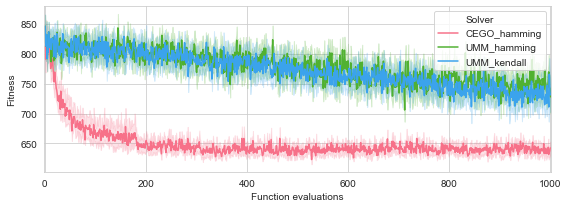

instance:  qap/kra30a.dat
Solver       eval_ranks  budget
UMM_kendall  0           1000      20000
dtype: int64
optimum:  88900
Saving to img/fitness_qap_kra30a_dat.pdf


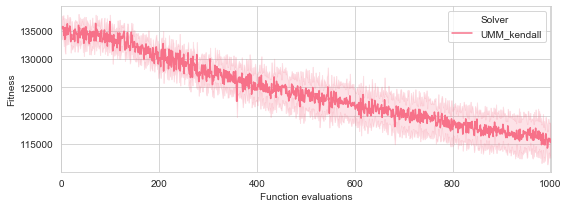

instance:  qap/kra30b.dat
Solver       eval_ranks  budget
UMM_kendall  0           1000      20000
dtype: int64
optimum:  91420
Saving to img/fitness_qap_kra30b_dat.pdf


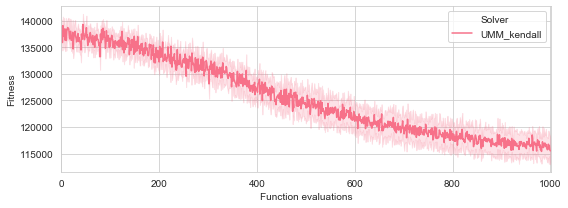

In [4]:
for inst in sel_insts:
  subdf = df[df.instance.str.contains(inst)].sort_values('Solver')
  print("instance: ", inst)
  print(subdf.groupby(['Solver', 'eval_ranks','budget' ]).size())
  if len(subdf) == 0: continue
  plt.figure(figsize=(8,3))
  val_opt = get_opt(inst)
  if val_opt is not None: 
    print("optimum: ", val_opt)
    if "lop" in inst: # Skip the PFSP and the QAP since the optimum is far and the plot will hide all the differences
        plt.plot([0,1000],[val_opt,val_opt])
  palette = sns.color_palette("husl", subdf['Solver'].nunique())
  g = sns.lineplot(x='Function evaluations', y='Fitness', hue='Solver', data=subdf, palette=palette)
  g.set(xlim=(-1, 1001))
  plt.tight_layout()
  filename = 'img/fitness_' + subdf.instance.iloc[0].replace('/','_').replace('.','_') + '.pdf'
  print("Saving to " + filename)
  plt.savefig(filename)
  plt.show()

## Summary table of the results

Table with the summary of the results

In [24]:
# The maximum time per seed and evaluation is the final time. 
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max().reset_index()
dftime
# Then we calculate the mean per instance.
dftime['run_time'] =  (dftime['run_time'] / 60.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time').reset_index()
dftime.columns.name  = ''
dftime
dftime['Instance'] = [i[-1] for i in dftime.instance.str.split('/').values]
dftime['Instance'] = dftime['Instance'].str.replace('.txt','').str.replace('.dat', '')
dftime = dftime.drop('instance',axis=1)
#dftime = dftime[['Problem', 'Instance', 'CEGO_inv', 'CEGO_orig', 'UMM_400', 'UMM_200', 'UMM_100']]
dftime#.sort_values(by='Instance')

print(dftime.to_latex(index=False))

\begin{tabular}{lrrrrrrrrrl}
\toprule
   Problem &  CEGO\_inv &  UMM\_400 &  UMM\_MaxMinDist &  UMM\_MaxMinDist\_nb &  UMM\_MaxMinDist\_rank &  UMM\_MaxMinDist\_sm001 &  UMM\_MaxMinDist\_sm01 &  UMM\_MaxMinDist\_sm1 &  UMM\_MaxMinDist\_smlen &    Instance \\
\midrule
       LOP &   1265.98 &     3.78 &            2.39 &               2.39 &                  NaN &                  0.91 &                 2.30 &                2.92 &                  2.43 &  N-t59b11xx \\
       LOP &   1269.93 &     3.93 &            2.41 &               2.33 &                  NaN &                  0.92 &                 2.27 &                2.40 &                  2.27 &  N-t59d11xx \\
       LOP &   1195.90 &     3.12 &            1.97 &               1.95 &                  NaN &                  0.76 &                 1.93 &                1.93 &                  1.91 &    N-p40-01 \\
       LOP &   1207.24 &     3.11 &            1.93 &               2.01 &                  NaN &                 

In [26]:
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
# df_fitness = df_fitness.groupby(['Solver','Problem','instance']).Fitness.agg(MeanFitness='mean').reset_index()
df_fitness = df_fitness.pivot_table(index=[ 'Problem', 'instance'],columns='Solver', values=['Fitness']).reset_index()

df_fitness.columns = [b if b!='' else a for (a,b)  in df_fitness.columns]
df_fitness['Instance'] = [i[-1] for i in df_fitness.instance.str.split('/').values]
df_fitness['Instance'] = df_fitness['Instance'].str.replace('.txt','').str.replace('.dat', '')
df_fitness = df_fitness.drop('instance',axis=1)
#df_fitness = df_fitness[['Problem', 'Instance', 'CEGO_inv', 'CEGO_orig', 'UMM_400',       'UMM_200', 'UMM_100']]
print(df_fitness)
print(df_fitness.to_latex(index=False))


      Problem   CEGO_inv    UMM_400  UMM_MaxMinDist  UMM_MaxMinDist_nb  \
0         LOP   102408.0   114726.5        112711.5           115024.0   
1         LOP    12692.2    16775.4         18619.1            20388.4   
2         LOP    10496.6    12453.7         12574.7            13254.7   
3         LOP    11714.7    13191.9         13416.8            13930.4   
4         LOP    18197.7    21306.5         21682.5            22495.6   
5         LOP    19090.5    22176.5         22317.4            23742.3   
6         LOP  1893533.2  1983521.2       1961382.7          1942011.2   
7         LOP  1895801.8  1973083.9       1989806.6          1953061.7   
8        PFSP     1276.2     1282.1             NaN                NaN   
9        PFSP     1992.9     2077.7             NaN                NaN   
10       PFSP     2264.5     2318.5             NaN                NaN   
11       PFSP     3415.5     3420.5             NaN                NaN   
12  PFSP-Cmax        NaN        NaN   

In [17]:
# Keep only one CEGO and one UMM
df = df[df.Solver.isin(['CEGO_inv','UMM_400'])]
# Make sure we have the right data
mask = ((df.budget==400) & (df.eval_ranks==0)&((df.budgetMM == 1) | (df.budgetMM.isna())))
df = df[mask]
df.Solver = df.Solver.str.replace('CEGO_inv','CEGO').str.replace('UMM_400', 'UMM')

# The maximum time per seed and evaluation is the final time.
dftime = df.groupby(['Solver','Problem','instance','seed']).run_time.max()
# Then we calculate the mean per instance.
dftime = dftime.groupby(['Solver','Problem','instance']).mean().reset_index()
# Convert to hours
dftime['run_time'] =  (dftime['run_time'] / 3600.0).round(1)
dftime = dftime.pivot_table(index=['Problem','instance'], columns='Solver',values='run_time')
dftime.rename(columns={'CEGO':'CEGO Runtime', 'UMM':'UMM Runtime'}, inplace=True)

# FEvals of CEGO
tmp = df[df.Solver == 'CEGO'].groupby(['Problem','instance','seed'])['Function evaluations'].max()
dftime['CEGO F. evaluations'] = tmp.groupby(['Problem','instance']).mean()

# Fitness
df_fitness = df.groupby(['Solver', 'Problem','instance','seed']).Fitness.min().reset_index()
tmp_cego = df_fitness[df_fitness.Solver == 'CEGO'].groupby(['Problem','instance']).Fitness.agg(CEGO_Fitness_mean='mean', CEGO_Fitness_std='std').reset_index()
tmp_umm = df_fitness[df_fitness.Solver == 'UMM'].groupby(['Problem','instance']).Fitness.agg(UMM_Fitness_mean='mean', UMM_Fitness_std='std').reset_index()
df = pd.merge(tmp_cego, tmp_umm)
# Fix instance names
df['Instance'] = [i[-1] for i in df.instance.str.split('/').values]
df['Instance'] = df['Instance'].str.replace('.txt','').str.replace('.dat', '')
df.CEGO_Fitness_mean = df.CEGO_Fitness_mean.round(1)
df.CEGO_Fitness_std = "(" + df.CEGO_Fitness_std.round(1).astype(str) + ")"
df.UMM_Fitness_mean = df.UMM_Fitness_mean.round(1)
df.UMM_Fitness_std = "(" + df.UMM_Fitness_std.round(1).astype(str) + ")"
df = pd.merge(df, dftime, on=['Problem', 'instance'])

df = df.sort_values(['Problem', 'UMM Runtime', 'CEGO Runtime'])

for inst in df.instance:
    x, y = [ f.to_numpy() for _, f in df_fitness[df_fitness.instance == inst].groupby('Solver').Fitness]
    cm = sms.CompareMeans(sms.DescrStatsW(x), sms.DescrStatsW(y))
    df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')])).replace('(','[').replace(')', ']')
    #df.loc[df.instance == inst, 'Confidence interval'] = str(tuple([i.round(1) for i in cm.tconfint_diff(usevar='unequal')]))

# Keep only some columns
df = df[['Problem', 'Instance','CEGO_Fitness_mean','CEGO_Fitness_std','UMM_Fitness_mean','UMM_Fitness_std','Confidence interval','CEGO Runtime','UMM Runtime']]
df.reset_index(drop=True)#.to_csv('info.csv')

,Problem,Instance,CEGO_Fitness_mean,CEGO_Fitness_std,UMM_Fitness_mean,UMM_Fitness_std,Confidence interval,CEGO Runtime,UMM Runtime
0,LOP,N-p40-01,10496.6,(116.8),12453.7,(513.3),"[-2328.4, -1585.8]",19.9,0.1
1,LOP,N-p40-02,11714.7,(84.7),13191.9,(430.0),"[-1787.3, -1167.1]",20.1,0.1
2,LOP,N-t59b11xx,102408.0,(3800.2),114726.5,(5052.4),"[-16542.0, -8095.0]",21.1,0.1
3,LOP,N-t59d11xx,12692.2,(1097.9),16775.4,(1950.4),"[-5599.4, -2567.0]",21.2,0.1
4,LOP,N-p50-02,19090.5,(285.4),22176.5,(555.1),"[-3511.0, -2661.0]",22.9,0.1
5,LOP,N-p50-01,18197.7,(225.6),21306.5,(574.4),"[-3535.2, -2682.4]",23.2,0.1
6,LOP,N-sgb75.01,1893533.2,(28594.6),1983521.2,(37422.8),"[-121433.3, -58542.7]",33.2,0.2
7,LOP,N-sgb75.02,1895801.8,(82847.9),1973083.9,(64611.8),"[-147381.6, -7182.6]",33.3,0.2
8,PFSP,rec19,2264.5,(45.0),2318.5,(73.3),"[-112.0, 4.0]",18.2,0.0
9,PFSP,rec05,1276.2,(15.1),1282.1,(17.2),"[-21.2, 9.4]",18.3,0.0


In [18]:
print(df.to_latex(index=False))

\begin{tabular}{llrlrllrr}
\toprule
Problem &    Instance &  CEGO\_Fitness\_mean & CEGO\_Fitness\_std &  UMM\_Fitness\_mean & UMM\_Fitness\_std &    Confidence interval &  CEGO Runtime &  UMM Runtime \\
\midrule
    LOP &    N-p40-01 &            10496.6 &          (116.8) &           12453.7 &         (513.3) &     [-2328.4, -1585.8] &          19.9 &          0.1 \\
    LOP &    N-p40-02 &            11714.7 &           (84.7) &           13191.9 &         (430.0) &     [-1787.3, -1167.1] &          20.1 &          0.1 \\
    LOP &  N-t59b11xx &           102408.0 &         (3800.2) &          114726.5 &        (5052.4) &    [-16542.0, -8095.0] &          21.1 &          0.1 \\
    LOP &  N-t59d11xx &            12692.2 &         (1097.9) &           16775.4 &        (1950.4) &     [-5599.4, -2567.0] &          21.2 &          0.1 \\
    LOP &    N-p50-02 &            19090.5 &          (285.4) &           22176.5 &         (555.1) &     [-3511.0, -2661.0] &          22.9 &          